In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa
import soundfile as sf
import numpy as np
import random
import wave
import scipy.signal
import IPython.display
import matplotlib.pyplot as plt
import librosa.display
import shutil

폴더 내 항목 모두 삭제

In [ ]:
def del_files_in_directory(folder_path):
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path) or os.path.islink(file_path):
          os.unlink(file_path)
      elif os.path.isdir(file_path):
          shutil.rmtree(file_path)

In [ ]:
del_files_in_directory('/content/증강된데이터')

폴더 내 파일 개수 세기

In [ ]:
def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])



## 함수들 정의

.wav로 확장자 변환

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment

def convert_audio_to_wav(input_path, output_path):
    # Check the file extension
    file_extension = input_path.split('.')[-1]

    if file_extension.lower() == 'mp3':
        audio = AudioSegment.from_mp3(input_path)
    elif file_extension.lower() == 'm4a':
        audio = AudioSegment.from_file(input_path, format='m4a')
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")

    audio.export(output_path, format="wav")

볼륨을 정규화

In [ ]:
def normalize_numpy(y, target_dBFS):
    rms = np.sqrt(np.mean(y**2))
    wave_dBFS = 20 * np.log10(rms)
    return y * (10 ** ((target_dBFS - wave_dBFS) / 20))


Adding Noise

In [ ]:
def add_noise(data, noise_rate):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_rate * noise
    # Cast back to same data type for sanity check
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

Volume Changing

In [ ]:
def change_volume(data, rate):
    data = data * rate  # 볼륨을 조정
    data = np.clip(data, -1.0, 1.0)  # 오디오 데이터가 -1.0에서 1.0 사이의 범위를 벗어나지 않도록. 볼륨을 높여도 소리가 왜곡되는 것을 방지
    return data

SpecAugment

In [ ]:
import random

# 시간 축뿐만 아니라 빈도 축(frequency axis)에 대해서도 마스킹을 적용
def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

        #주파수 마스킹
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        spec[:, int(f0):int(f0 + num_freqs_to_mask)] = 0

        #시간 마스킹
        time_percentage = random.uniform(0.0, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        spec[int(t0):int(t0 + num_frames_to_mask), :] = 0

    return spec

Audio Mixing

In [ ]:
def get_audio_info(audio_path):
    """Returns the sample rate and number of channels in the audio file."""
    with wave.open(audio_path, 'rb') as wav:
        return wav.getframerate(), wav.getnchannels()

# 샘플링 속도와 채널 수를 맞추기 위한 함수
def resample_and_adjust_channels(audio, sr, target_sr):
    """Resamples the audio and adjusts the number of channels."""
    # Resample
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

    # If the audio has more than one channel (stereo), convert it to mono
    if audio.ndim > 1:
        audio = librosa.to_mono(audio)

    return audio

def audio_mix(data1, data2, mix_rate=0.5):
    # 두 오디오 신호의 길이가 같아지도록 data2를 반복
    num_repeats = np.ceil(len(data1) / len(data2)).astype(int)
    data2_extended = np.tile(data2, num_repeats)

    # data2_extended의 길이를 data1과 같게 만듦
    data2_extended = data2_extended[:len(data1)]

    # 두 오디오 신호를 믹싱
    mixed = mix_rate * data1 + (1 - mix_rate) * data2_extended

    # 두 오디오 신호를 더한 값이 -1과 1 사이의 범위에 오도록
    norm = np.max(np.abs(mixed))
    mixed_normalized = mixed / norm

    # 볼륨 클리핑
    mixed_clipped = np.clip(mixed_normalized, -1.0, 1.0)

    return mixed_clipped


Shifting

In [ ]:
def shift(data, shift_max=2, shift_direction='right'):
    dim = np.ndim(data) - 1
    shift = np.random.randint(data.shape[dim] * shift_max)  # 입력 data의 차원 수에 따라 적절한 차원 인덱스를 선택하여 shift 값을 계산
    if shift_direction == 'right':
        shift = -shift
    return np.roll(data, shift)

## .wav로 확장자 변환

In [ ]:
# Convert audio files to .wav format
source_dir = '/content/drive/MyDrive/음성인식_프로젝트/1. 당고개-오이도(하선)'
target_dir = '/content/변환된데이터'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for filename in os.listdir(source_dir):
    if filename.endswith(('.mp3', '.m4a')):  # Only process .mp3 or .m4a files
        input_path = os.path.join(source_dir, filename)

        # 파일 이름에서 확장자를 제거하고 .wav를 붙입니다.
        name, ext = os.path.splitext(filename)
        output_path = os.path.join(target_dir, name + '.wav')

        convert_audio_to_wav(input_path, output_path)

In [ ]:
directory_path = source_dir
print(count_files_in_directory(directory_path))

60


In [ ]:
directory_path = target_dir
print(count_files_in_directory(directory_path))

60


In [ ]:
convert_audio_to_wav("소음.m4a", "소음.wav")

##데이터 증강

In [ ]:
# Define directories
source_dir = '/content/변환된데이터'
target_dir = '/content/증강된데이터'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# 원본 파일과 믹싱할 파일 로드(지하철내 소음)
data2, sr2 = librosa.load('소음.wav', sr=None)

# Loop over source directory
for filename in os.listdir(source_dir):
    if filename.endswith(".wav"):  # Only process .wav files
        data, sr = librosa.load(os.path.join(source_dir, filename), sr=None)
        data = data.astype(np.float32)

        # Normalize the volume of data to a target dBFS
        data = normalize_numpy(data, -20)

        # Convert the normalized data to mono if it is not
        if data.ndim > 1:
            data = librosa.to_mono(data)

        # Adding Noise
        data_add_noise = add_noise(data, 0.02)

        # Volume Changing
        data_change_volume = change_volume(data, 1.5)

        # SpecAugment
        D = librosa.stft(data)  # 원본 오디오 데이터를 스펙토그램으로 변환
        D_spec_augment = spec_augment(D)  # STFT 변환된 데이터 D에 SpecAugment를 적용
        data_spec_augment = librosa.istft(D_spec_augment)  # SpecAugment된 STFT 데이터를 다시 오디오 데이터로 변환


        # Audio Mixing

        # Normalize the volume of data2 to a target dBFS
        data2 = normalize_numpy(data2, -30)

        # Convert the normalized data2 to mono if it is not
        if data2.ndim > 1:
            data2 = librosa.to_mono(data2)

        # Resample and adjust channels
        target_sr = min(sr, sr2)
        data = resample_and_adjust_channels(data, sr, target_sr)
        data2 = resample_and_adjust_channels(data2, sr2, target_sr)

        # Check for audio clipping
        assert np.max(data) <= 1, "Clipping detected in data: max amplitude = {}".format(np.max(data))
        assert np.max(data2) <= 1, "Clipping detected in data2: max amplitude = {}".format(np.max(data2))

        # Ensure same data type
        assert data.dtype == data2.dtype, "Mismatched dtypes: {}, {}".format(data.dtype, data2.dtype)

        data_audio_mix = audio_mix(data, data2)  #(지하철 안내방송 음원, 소음 음성) 순서여야 함
        # Shifting
        data_shift = shift(data)


        # Save augmented data
        new_filename = filename.rsplit('.', 1)[0]
        sf.write(os.path.join(target_dir, new_filename + '_noise.wav'), data_add_noise, sr)
        sf.write(os.path.join(target_dir, new_filename + '_volume.wav'), data_change_volume, sr)
        sf.write(os.path.join(target_dir, new_filename + '_spec.wav'), data_spec_augment, sr)
        sf.write(os.path.join(target_dir, new_filename + '_mix.wav'), data_audio_mix, target_sr)
        sf.write(os.path.join(target_dir, new_filename + '_shift.wav'), data_shift, sr)


In [ ]:
directory_path = source_dir
print(count_files_in_directory(directory_path))

60


In [ ]:
directory_path = target_dir
print(count_files_in_directory(directory_path))

300


## 증강 결과 확인

원본 데이터

In [ ]:
# Load an audio file
file_path = os.path.join(source_dir, "40. 한대앞.wav")
data, sr = librosa.load(file_path)

IPython.display.Audio(data=data, rate=sr)

Adding Noise

In [ ]:
file_path = os.path.join(directory_path, "40. 한대앞_noise.wav")
data_add_noise, sr = librosa.load(file_path)

IPython.display.Audio(data=data_add_noise, rate=sr)

증강된 waveform 표시

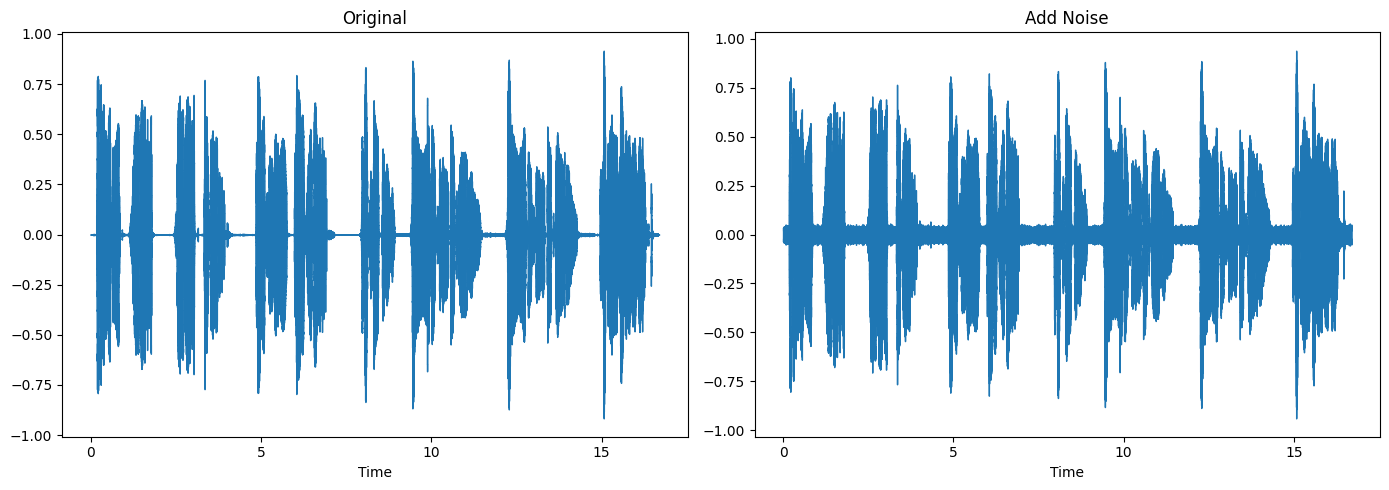

In [ ]:
# Plot original and augmented waveforms
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(data, sr=sr)
plt.title('Original')
plt.subplot(1, 2, 2)
librosa.display.waveshow(data_add_noise, sr=sr)
plt.title('Add Noise')
plt.tight_layout()
plt.show()

Volume Changing

In [ ]:
file_path = os.path.join(directory_path, "40. 한대앞_volume.wav")
data_change_volume, sr = librosa.load(file_path)

IPython.display.Audio(data=data_change_volume, rate=sr)

증강된 waveform 표시

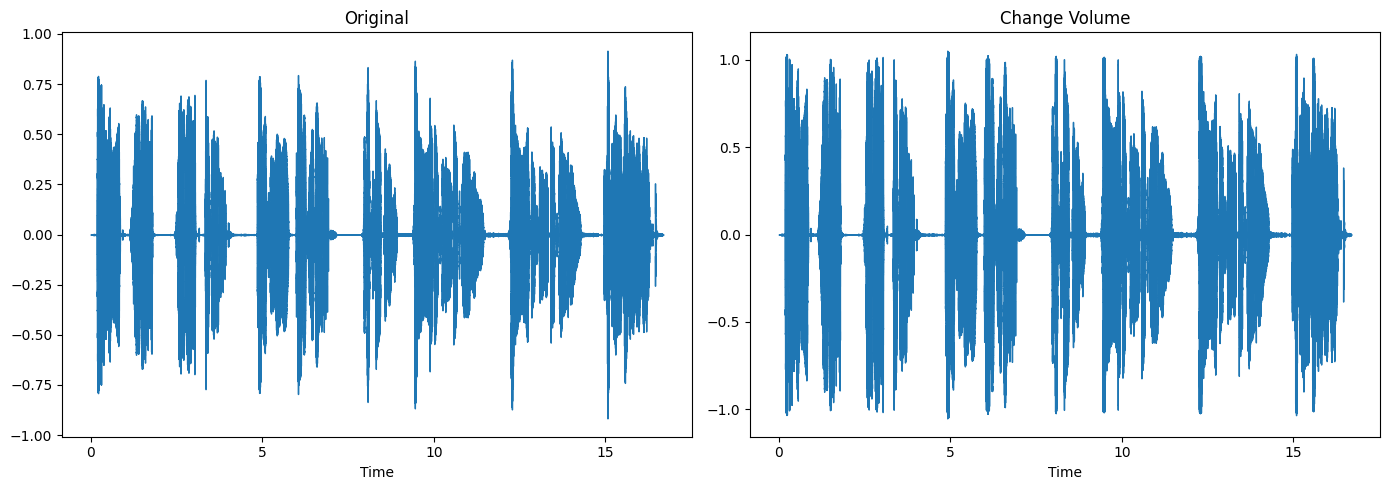

In [ ]:
# Plot original and augmented waveforms
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(data, sr=sr)
plt.title('Original')
plt.subplot(1, 2, 2)
librosa.display.waveshow(data_change_volume, sr=sr)
plt.title('Change Volume')
plt.tight_layout()
plt.show()

SpecAugment

In [ ]:
file_path = os.path.join(directory_path, "40. 한대앞_spec.wav")
data_spec_augment, sr = librosa.load(file_path)

IPython.display.Audio(data=data_spec_augment, rate=sr)

증강된 spectogram 표시 (SpecAugment에서는 spectogram을 비교하는 것이 적절)

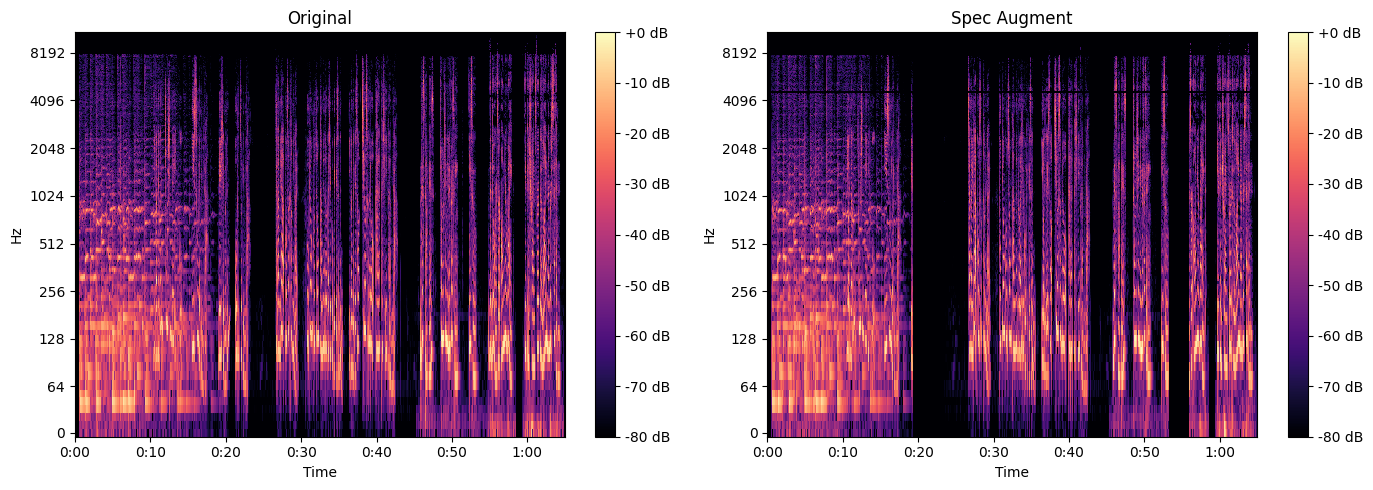

In [ ]:
# Convert back to dB
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)  # 스펙토그램을 시각화하기 위해 STFT 변환된 데이터 D를 dB 단위로 변환
D_spec_augment_db = librosa.amplitude_to_db(np.abs(D_spec_augment), ref=np.max)  # SpecAugment가 적용된 데이터 D_spec_augment를 dB 단위로 변환

# Plot original and augmented spectrograms
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')  # D_db의 스펙토그램 (원래 스펙토그램)
plt.colorbar(format='%+2.0f dB')
plt.title('Original')
plt.subplot(1, 2, 2)
librosa.display.specshow(D_spec_augment_db, sr=sr, x_axis='time', y_axis='log')  # D_spec_augment_db의 스펙토그램 (증강된 스펙토그램)
plt.colorbar(format='%+2.0f dB')
plt.title('Spec Augment')
plt.tight_layout()
plt.show()

Audio Mixing

In [ ]:
file_path = os.path.join(target_dir, "40. 한대앞_mix.wav")
data_audio_mix, target_sr = librosa.load(file_path)

IPython.display.Audio(data=data_audio_mix, rate=target_sr)

In [ ]:
file_path = os.path.join(target_dir, "40. 한대앞_mix.wav")
data_audio_mix, target_sr = librosa.load(file_path)

IPython.display.Audio(data=data_audio_mix, rate=target_sr)

증강된 waveform 표시

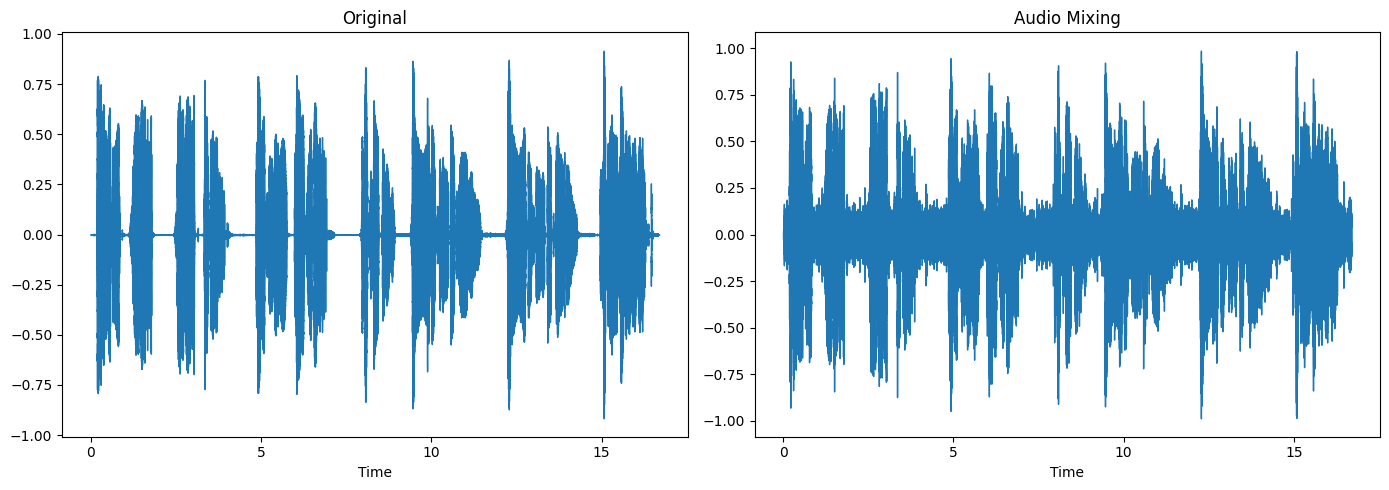

In [ ]:
# Plot original and augmented waveforms
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(data, sr=sr)
plt.title('Original')
plt.subplot(1, 2, 2)
librosa.display.waveshow(data_audio_mix, sr=target_sr)
plt.title('Audio Mixing')
plt.tight_layout()
plt.show()

Shifting

In [ ]:
file_path = os.path.join(directory_path, "40. 한대앞_shift.wav")
data_shift, sr = librosa.load(file_path)

IPython.display.Audio(data=data_shift, rate=sr)

증강된 waveform 표시

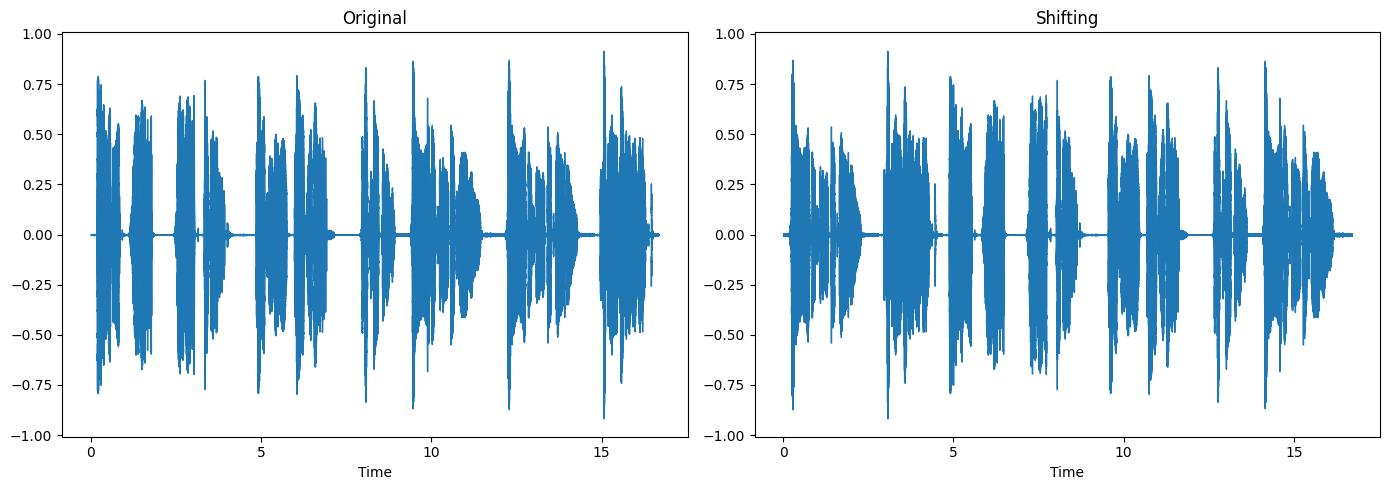

In [ ]:
# Plot original and augmented waveforms
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(data, sr=sr)
plt.title('Original')
plt.subplot(1, 2, 2)
librosa.display.waveshow(data_shift, sr=sr)
plt.title('Shifting')
plt.tight_layout()
plt.show()